/usr/local/spark/python/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(



----------------------------
Eurasian Blue Tit: 8 mal erkannt


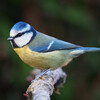

Great Spotted Woodpecker: 1 mal erkannt


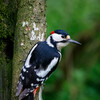

Eurasian Treecreeper: 1 mal erkannt


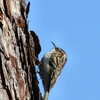

Redwing: 1 mal erkannt


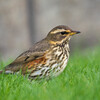

Long-tailed Tit: 3 mal erkannt


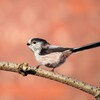

House Sparrow: 23 mal erkannt


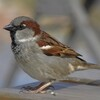

Great Tit: 54 mal erkannt


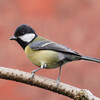

Eurasian Magpie: 16 mal erkannt


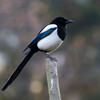


----------------------------
Eurasian Jackdaw: 3 mal erkannt


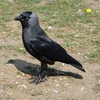

Song Thrush: 20 mal erkannt


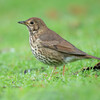

Eurasian Tree Sparrow: 2 mal erkannt


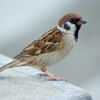

Eurasian Blue Tit: 64 mal erkannt


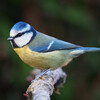

Common Firecrest: 5 mal erkannt


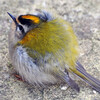

Mallard: 1 mal erkannt


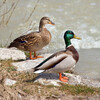

Great Spotted Woodpecker: 1 mal erkannt


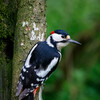

Short-toed Treecreeper: 1 mal erkannt


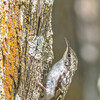

Common Chaffinch: 1 mal erkannt


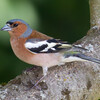

Hawfinch: 2 mal erkannt


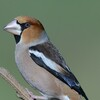

Eurasian Coot: 7 mal erkannt


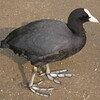

Goldcrest: 2 mal erkannt


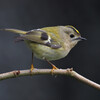

Graylag Goose: 1 mal erkannt


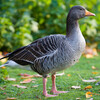

Common Raven: 1 mal erkannt


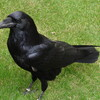

Marsh Tit: 1 mal erkannt


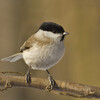

Redwing: 5 mal erkannt


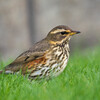

Fieldfare: 1 mal erkannt


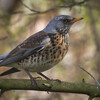

Carrion Crow: 2 mal erkannt


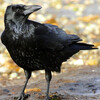

House Sparrow: 2 mal erkannt


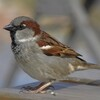

Long-tailed Tit: 22 mal erkannt


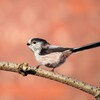

Tawny Owl: 2 mal erkannt


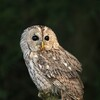

Willow Tit: 2 mal erkannt


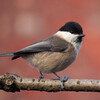

Eurasian Collared-Dove: 3 mal erkannt


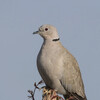

Great Tit: 322 mal erkannt


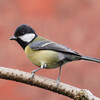

Eurasian Magpie: 14 mal erkannt


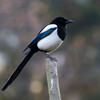

Common Buzzard: 1 mal erkannt


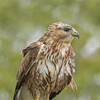

Eurasian Moorhen: 2 mal erkannt


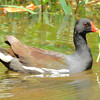

European Greenfinch: 2 mal erkannt


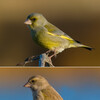

European Goldfinch: 3 mal erkannt


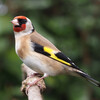

European Robin: 1 mal erkannt


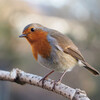

Green-winged Teal: 1 mal erkannt


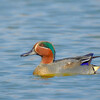


----------------------------
Eurasian Jackdaw: 1 mal erkannt


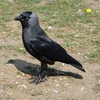

Song Thrush: 22 mal erkannt


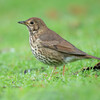

Eurasian Blue Tit: 28 mal erkannt


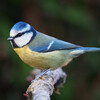

Common Firecrest: 8 mal erkannt


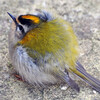

Mallard: 3 mal erkannt


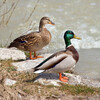

Eurasian Blackbird: 4 mal erkannt


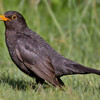

Eurasian Coot: 4 mal erkannt


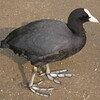

Goldcrest: 4 mal erkannt


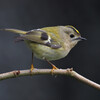

Eurasian Treecreeper: 1 mal erkannt


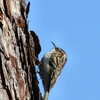

Marsh Tit: 4 mal erkannt


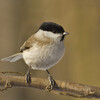

Redwing: 5 mal erkannt


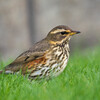

Eurasian Siskin: 3 mal erkannt


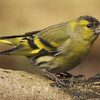

Crested Tit: 2 mal erkannt


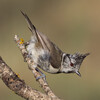

Long-tailed Tit: 2 mal erkannt


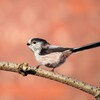

Carrion Crow: 4 mal erkannt


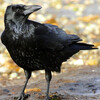

Water Rail: 2 mal erkannt


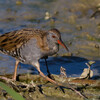

Tawny Owl: 4 mal erkannt


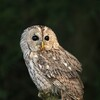

Eurasian Magpie: 21 mal erkannt


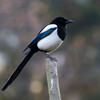

Great Tit: 116 mal erkannt


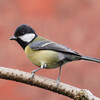

Black Redstart: 2 mal erkannt


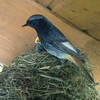

European Robin: 253 mal erkannt


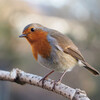

Green-winged Teal: 4 mal erkannt


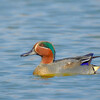


----------------------------
Eurasian Tree Sparrow: 5 mal erkannt


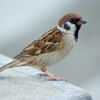

Eurasian Jackdaw: 1 mal erkannt


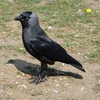

Eurasian Blue Tit: 90 mal erkannt


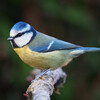

European Serin: 1 mal erkannt


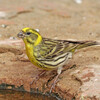

Common Chaffinch: 11 mal erkannt


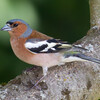

Coal Tit: 5 mal erkannt


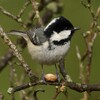

Common Firecrest: 18 mal erkannt


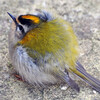

Hawfinch: 1 mal erkannt


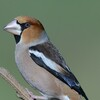

Goldcrest: 4 mal erkannt


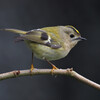

Eurasian Treecreeper: 1 mal erkannt


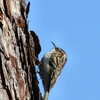

Marsh Tit: 4 mal erkannt


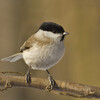

Dunnock: 2 mal erkannt


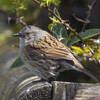

Redwing: 1 mal erkannt


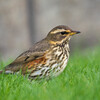

Eurasian Jay: 6 mal erkannt


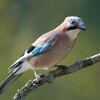

Eurasian Bullfinch: 1 mal erkannt


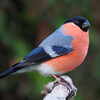

Fieldfare: 1 mal erkannt


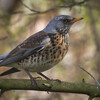

Carrion Crow: 2 mal erkannt


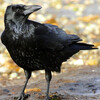

House Sparrow: 4 mal erkannt


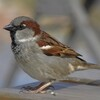

Eurasian Collared-Dove: 2 mal erkannt


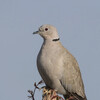

Eurasian Magpie: 49 mal erkannt


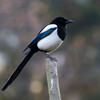

Great Tit: 171 mal erkannt


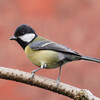

Gray Wagtail: 4 mal erkannt


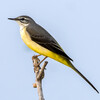

European Robin: 110 mal erkannt


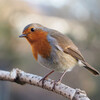

European Greenfinch: 4 mal erkannt


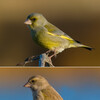

In [ ]:
import json
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from IPython.display import display

def main(timeout, func, window):
    sc = SparkContext("local[*]", "Streaming-Aggregation")
    ssc = StreamingContext(sc, window)
    stream = ssc.socketTextStream("127.0.0.1", 9999)
    func(stream)  # ✅ Hier wird die Aggregation pro Window durchgeführt

    try:
        ssc.start()
        ssc.awaitTerminationOrTimeout(timeout)
    except Exception as e:
        print(str(e))
    finally:
        ssc.stop(False)

def aggregate_common_name_with_image(stream):
    def safe_parse(line):
        """Parst JSON und extrahiert die Spezies + Bild-URL"""
        try:
            obj = json.loads(line)
            return (obj['species']['commonName'], (1, obj['species']['thumbnailUrl']))
        except Exception as e:
            return ("Fehler", (0, ""))  # Fehlerhandling

    parsed_stream = stream.map(safe_parse)

    # **Nur innerhalb des aktuellen Windows aggregieren** 
    aggregated_stream = parsed_stream.reduceByKey(lambda a, b: (a[0] + b[0], a[1])) 

    def show_images(rdd):
        """Zeigt die aggregierten Ergebnisse + Bilder an"""
        results = rdd.collect()
        if results:
            print("\n----------------------------")  # 🔥 Trennlinie zwischen Windows
            for species, (count, url) in results:
                print(f"{species}: {count} mal erkannt")
                if url:
                    show_image_from_url(url)

    aggregated_stream.foreachRDD(show_images)  # 🔥 OUTPUT-OPERATION!

def show_image_from_url(url):
    """Lädt ein Bild von der URL und zeigt es direkt in Jupyter Notebook an."""
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        display(img)  # 🔥 Zeigt das Bild direkt in Jupyter Notebook an
    except Exception as e:
        print(f"Fehler beim Laden des Bildes: {e}")

# **Starte Spark Streaming mit 30s Timeout, Aggregation und 5s Fenstergröße**
main(1000, aggregate_common_name_with_image, 50)


In [1]:
import json
import pandas as pd
from tabulate import tabulate
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, window, count, first, lit
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

# 🏗 Spark Session starten
spark = SparkSession.builder \
    .appName("Structured-Streaming-Aggregation") \
    .master("local[*]") \
    .getOrCreate()

# 📜 JSON-Schema
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("timestamp", StringType(), True),
    StructField("species", StructType([
        StructField("commonName", StringType(), True),
        StructField("thumbnailUrl", StringType(), True)
    ]), True)
])

# 📡 Eingehender Datenstrom von Socket (Port 9999)
raw_stream = spark.readStream \
    .format("socket") \
    .option("host", "127.0.0.1") \
    .option("port", 9999) \
    .load()

# 🛠 JSON parsen und Timestamp konvertieren
parsed_stream = raw_stream.select(from_json(col("value"), schema).alias("data")) \
    .select(
        col("data.id"),
        col("data.species.commonName").alias("species_name"),
        col("data.species.thumbnailUrl").alias("image_url"),
        col("data.timestamp").cast(TimestampType()).alias("timestamp")
    )

# ⏳ Window-basierte Aggregation (1-Minuten-Fenster)
aggregated_stream = parsed_stream \
    .withWatermark("timestamp", "2 minutes") \
    .groupBy(window(col("timestamp"), "1 minute"), col("species_name")) \
    .agg(
        count("*").alias("count"),
        first("image_url").alias("image_url")
    ) \
    .dropDuplicates(["window", "species_name"])  # Doppelte Einträge entfernen

# 📸 Funktion zum Laden & Anzeigen von Bildern
def show_image_from_url(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        display(img)
    except Exception as e:
        print(f"Fehler beim Laden des Bildes: {e}")

# 🖥 Ausgabe als Tabelle mit Fenster-Info
def display_results(df, epoch_id):
    results = df.collect()
    
    if results:
        # ⏳ Fensterzeitraum extrahieren
        window_start = results[0]["window"]["start"]
        window_end = results[0]["window"]["end"]
        print(f"\n===== Aggregation für Fenster: {window_start} bis {window_end} =====")

        # 📊 Daten in eine Tabelle umwandeln
        data = [{"Art": row["species_name"], "Anzahl": row["count"], "Bild": row["image_url"]} for row in results]
        df_table = pd.DataFrame(data)

        # 🖥 Formatiert als Tabelle ausgeben
        print(tabulate(df_table, headers="keys", tablefmt="grid"))

        # 📸 Bilder anzeigen (nur ein Bild pro Spezies)
        for row in results:
            print(f"\n{row['species_name']} (Anzahl: {row['count']})")
            if row["image_url"]:
                show_image_from_url(row["image_url"])

# ✨ Streaming-Query starten mit Update-Trigger alle 1 Minute
query = aggregated_stream.writeStream \
    .outputMode("update") \
    .foreachBatch(display_results) \
    .trigger(processingTime="1 minute") \
    .start()

query.awaitTermination()


AnalysisException: Detected pattern of possible 'correctness' issue due to global watermark. The query contains stateful operation which can emit rows older than the current watermark plus allowed late record delay, which are "late rows" in downstream stateful operations and these rows can be discarded. Please refer the programming guide doc for more details. If you understand the possible risk of correctness issue and still need to run the query, you can disable this check by setting the config `spark.sql.streaming.statefulOperator.checkCorrectness.enabled` to false.;
Deduplicate [window#15-T120000ms, species_name#4]
+- Aggregate [window#24-T120000ms, species_name#4], [window#24-T120000ms AS window#15-T120000ms, species_name#4, count(1) AS count#21L, first(image_url#5, false) AS image_url#23]
   +- Project [named_struct(start, knownnullable(precisetimestampconversion(((precisetimestampconversion(timestamp#6-T120000ms, TimestampType, LongType) - CASE WHEN (((precisetimestampconversion(timestamp#6-T120000ms, TimestampType, LongType) - 0) % 60000000) < cast(0 as bigint)) THEN (((precisetimestampconversion(timestamp#6-T120000ms, TimestampType, LongType) - 0) % 60000000) + 60000000) ELSE ((precisetimestampconversion(timestamp#6-T120000ms, TimestampType, LongType) - 0) % 60000000) END) - 0), LongType, TimestampType)), end, knownnullable(precisetimestampconversion((((precisetimestampconversion(timestamp#6-T120000ms, TimestampType, LongType) - CASE WHEN (((precisetimestampconversion(timestamp#6-T120000ms, TimestampType, LongType) - 0) % 60000000) < cast(0 as bigint)) THEN (((precisetimestampconversion(timestamp#6-T120000ms, TimestampType, LongType) - 0) % 60000000) + 60000000) ELSE ((precisetimestampconversion(timestamp#6-T120000ms, TimestampType, LongType) - 0) % 60000000) END) - 0) + 60000000), LongType, TimestampType))) AS window#24-T120000ms, id#7, species_name#4, image_url#5, timestamp#6-T120000ms]
      +- Filter isnotnull(timestamp#6-T120000ms)
         +- EventTimeWatermark timestamp#6: timestamp, 2 minutes
            +- Project [data#2.id AS id#7, data#2.species.commonName AS species_name#4, data#2.species.thumbnailUrl AS image_url#5, cast(data#2.timestamp as timestamp) AS timestamp#6]
               +- Project [from_json(StructField(id,IntegerType,true), StructField(timestamp,StringType,true), StructField(species,StructType(StructField(commonName,StringType,true),StructField(thumbnailUrl,StringType,true)),true), value#0, Some(Etc/UTC)) AS data#2]
                  +- StreamingRelationV2 org.apache.spark.sql.execution.streaming.sources.TextSocketSourceProvider@29a3a8a7, socket, org.apache.spark.sql.execution.streaming.sources.TextSocketTable@776fc86a, [host=127.0.0.1, port=9999], [value#0]
